In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA


In [2]:
np.random.seed(42)

dates = pd.date_range(start="2023-01-01", periods=104, freq="W")
skus = ["A", "B", "C"]

data = []

for sku in skus:
    base = np.random.randint(80, 150)
    trend = np.linspace(0, 20, len(dates))
    seasonality = 10 * np.sin(np.linspace(0, 3*np.pi, len(dates)))
    noise = np.random.normal(0, 8, len(dates))
    
    demand = base + trend + seasonality + noise
    
    for i, d in enumerate(demand):
        data.append([
            dates[i], 
            sku, 
            max(0, int(d)),
            np.random.randint(1, 4), 
            np.random.uniform(3, 6)
        ])

df = pd.DataFrame(data, columns=["date", "sku", "demand", "lead_time", "unit_cost"])
df.head()


,date,sku,demand,lead_time,unit_cost
0,2023-01-01,A,122,1,3.444261
1,2023-01-08,A,134,1,3.800343
2,2023-01-15,A,135,2,4.508037
3,2023-01-22,A,142,2,3.099152
4,2023-01-29,A,130,1,4.903054


In [5]:
sku_A = df[df["sku"] == "A"].set_index("date")["demand"]

model = ARIMA(sku_A, order=(2,1,2))
fit = model.fit()

forecast = fit.forecast(12)
forecast


C:\Users\maxwe\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\maxwe\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\maxwe\AppData\Local\Programs\Python\Python314\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


2024-12-29    145.876710
2025-01-05    149.463062
2025-01-12    146.929823
2025-01-19    149.092749
2025-01-26    147.266046
2025-02-02    148.809681
2025-02-09    147.505290
2025-02-16    148.607518
2025-02-23    147.676120
2025-03-02    148.463165
2025-03-09    147.798101
2025-03-16    148.360089
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [6]:
Z = 1.65  # 95% service level
std_demand = sku_A.std()
lead_time = df[df["sku"]=="A"]["lead_time"].mean()

safety_stock = Z * std_demand * np.sqrt(lead_time)
avg_demand = sku_A.mean()
reorder_point = (avg_demand * lead_time) + safety_stock

safety_stock, reorder_point


(np.float64(27.963385709307918), np.float64(307.0865365968819))

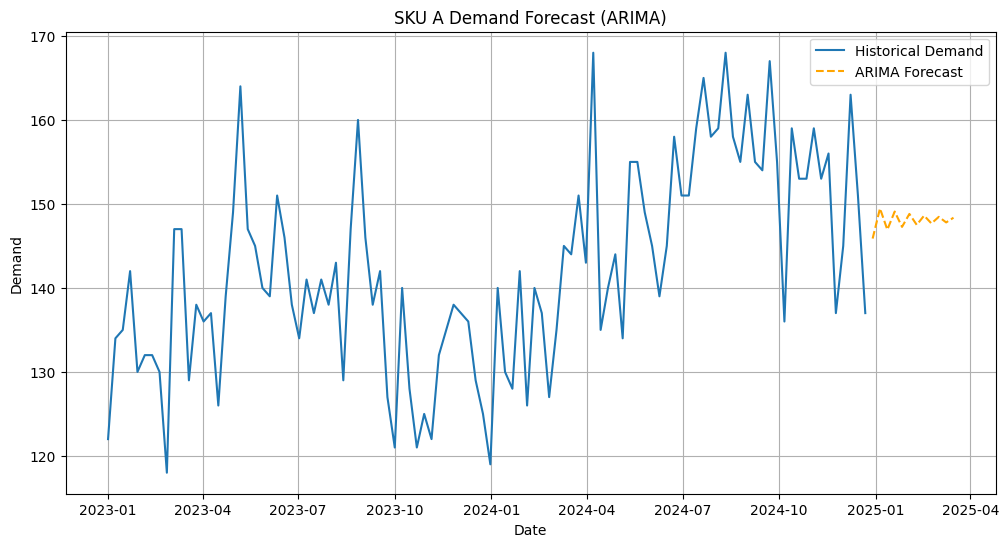

In [7]:
plt.figure(figsize=(12,6))
plt.plot(sku_A, label="Historical Demand")
plt.plot(forecast, label="ARIMA Forecast", linestyle="--", color="orange")
plt.title("SKU A Demand Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
demand_spike = forecast * 1.15
lead_time_increase = lead_time * 1.5

new_safety_stock = Z * std_demand * np.sqrt(lead_time_increase)
new_reorder_point = (avg_demand * lead_time_increase) + new_safety_stock

new_safety_stock, new_reorder_point


(np.float64(34.24801323421973), np.float64(452.9327395655807))

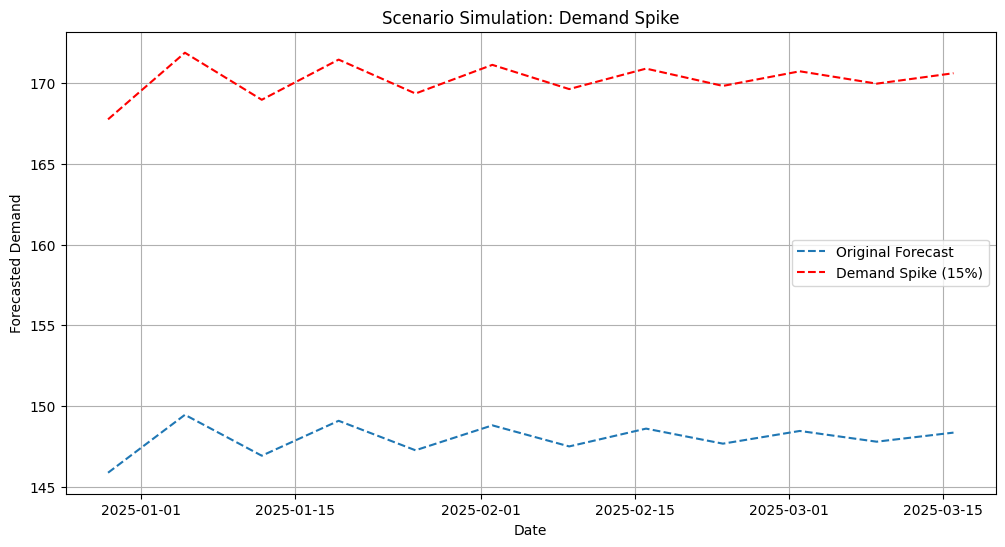

In [9]:
plt.figure(figsize=(12,6))
plt.plot(forecast, label="Original Forecast", linestyle="--")
plt.plot(demand_spike, label="Demand Spike (15%)", linestyle="--", color="red")
plt.title("Scenario Simulation: Demand Spike")
plt.xlabel("Date")
plt.ylabel("Forecasted Demand")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
print("🔍 Business Insights:")
print(f"- Safety Stock (95% service level): {safety_stock:.2f} units")
print(f"- Reorder Point: {reorder_point:.2f} units")
print(f"- New Safety Stock (with 50% lead time increase): {new_safety_stock:.2f} units")
print(f"- New Reorder Point (with 50% lead time increase): {new_reorder_point:.2f} units")


🔍 Business Insights:
- Safety Stock (95% service level): 27.96 units
- Reorder Point: 307.09 units
- New Safety Stock (with 50% lead time increase): 34.25 units
- New Reorder Point (with 50% lead time increase): 452.93 units
